# Practical 5: Self-Supervised Contrastive Learning with SimCLR

**Open notebook:**
[![View on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/asci_cbl_practicals/blob/main/notebooks/5_Self_Supervised_Learning.ipynb)
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/phlippe/asci_cbl_practicals/blob/main/notebooks/5_Self_Supervised_Learning.ipynb)    
**Authors:** Phillip Lippe

In [32]:
Colab_server=False
import os
from pytorch_lightning.callbacks import TQDMProgressBar
if Colab_server:
    from google.colab import drive
    drive.mount('/content/drive',force_remount=True)

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "/home/ehsan/data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "/home/ehsan/saved_models/practical5"
if Colab_server:
    DATASET_PATH = "../data"
    CHECKPOINT_PATH = "/content/drive/MyDrive/saved_models/practical5"
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

#!jupyter nbconvert --to script ...ipynb

print(os.listdir(CHECKPOINT_PATH))

if not Colab_server:
    import os
    os.environ['TENSORBOARD_BINARY'] = '/home/ehsan/.local/bin/tensorboard'


['SimCLR', 'LogisticRegression']


In this practical, we will take a closer look at self-supervised contrastive learning. Self-supervised learning, or also sometimes called unsupervised learning, describes the scenario where we have given input data, but no accompanying labels to train in a classical supervised way. However, this data still contains a lot of information from which we can learn: how are the images different from each other? What patterns are descriptive for certain images? Can we cluster the images? And so on. Methods for self-supervised learning try to learn as much as possible from the data alone, so it can quickly be finetuned for a specific classification task.
The benefit of self-supervised learning is that a large dataset can often easily be obtained. For instance, if we want to train a vision model on semantic segmentation for autonomous driving, we can collect large amounts of data by simply installing a camera in a car, and driving through a city for an hour. In contrast, if we would want to do supervised learning, we would have to manually label all those images before training a model. This is extremely expensive, and would likely take a couple of months to manually label the same amount of data. Further, self-supervised learning can provide an alternative to transfer learning from models pretrained on ImageNet since we could pretrain a model on a specific dataset/situation, e.g. traffic scenarios for autonomous driving.

Within the last two years, a lot of new approaches have been proposed for self-supervised learning, in particular for images, that have resulted in great improvements over supervised models when few labels are available. The subfield that we will focus on in this tutorial is contrastive learning. Contrastive learning is motivated by the question mentioned above: how are images different from each other? Specifically, contrastive learning methods train a model to cluster an image and its slightly augmented version in latent space, while the distance to other images should be maximized. A very recent and simple method for this is [SimCLR](https://arxiv.org/abs/2006.10029), which is visualized below (figure credit - [Ting Chen et al.](https://simclr.github.io/)).

<center width="100%"><img src="https://github.com/Ehsan-aghapour/asci_cbl_practicals/blob/main/notebooks/figures/simclr_contrastive_learning.png?raw=1" width="500px"></center>

The general setup is that we are given a dataset of images without any labels, and want to train a model on this data such that it can quickly adapt to any image recognition task afterward. During each training iteration, we sample a batch of images as usual. For each image, we create two versions by applying data augmentation techniques like cropping, Gaussian noise, blurring, etc. An example of such is shown on the left with the image of the dog. We will go into the details and effects of the chosen augmentation techniques later. On those images, we apply a CNN like ResNet and obtain as output a 1D feature vector on which we apply a small MLP. The output features of the two augmented images are then trained to be close to each other, while all other images in that batch should be as different as possible. This way, the model has to learn to recognize the content of the image that remains unchanged under the data augmentations, such as objects which we usually care about in supervised tasks.

We will now implement this framework ourselves and discuss further details along the way. Let's first start with importing our standard libraries below:

In [33]:
## Standard libraries
import os
import numpy as np
import random
import math
import json
from functools import partial
from PIL import Image

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

## tqdm for loading bars
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## Torchvision
import torchvision
from torchvision.datasets import CIFAR10, STL10
from torchvision import transforms

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.6
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Import tensorboard
%load_ext tensorboard

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
##DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
##CHECKPOINT_PATH = "../saved_models/practical5"

# Setting the seed
pl.seed_everything(42)
# In this notebook, we use data loaders with heavier computational processing. It is recommended to use as many
# workers as possible in a data loader, which corresponds to the number of CPU cores
NUM_WORKERS = os.cpu_count()

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)
print("Number of workers:", NUM_WORKERS)

Seed set to 42


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Device: cuda:0
Number of workers: 16


## Data Augmentation for Contrastive Learning

We will start our exploration of contrastive learning by discussing the effect of different data augmentation techniques, and how we can implement an efficient data loader for such. To allow efficient training, we need to prepare the data loading such that we sample two different, random augmentations for each image in the batch. The easiest way to do this is by creating a transformation that, when being called, applies a set of data augmentations to an image twice. This is implemented in the class `ContrastiveTransformations` below:

In [34]:
class ContrastiveTransformations(object):

    def __init__(self, base_transforms, n_views=2):
        self.base_transforms = base_transforms
        self.n_views = n_views

    def __call__(self, x):
        return [self.base_transforms(x) for i in range(self.n_views)]

The contrastive learning framework can easily be extended to have more _positive_ examples by sampling more than two augmentations of the same image. However, the most efficient training is usually obtained by using only two.

Next, we can look at the specific augmentations we want to apply. The choice of the data augmentation to use is the most crucial hyperparameter in SimCLR since it directly affects how the latent space is structured, and what patterns might be learned from the data. Let's first take a look at some of the most popular data augmentations (figure credit - [Ting Chen and Geoffrey Hinton](https://ai.googleblog.com/2020/04/advancing-self-supervised-and-semi.html)):

<center width="100%"><img src="https://github.com/Ehsan-aghapour/asci_cbl_practicals/blob/main/notebooks/figures/simclr_data_augmentations.png?raw=1" width="800px" style="padding-top: 10px; padding-bottom: 10px"></center>

All of them can be used, but it turns out that two augmentations stand out in their importance: crop-and-resize, and color distortion. Interestingly, however, they only lead to strong performance if they have been used together as discussed by [Ting Chen et al.](https://arxiv.org/abs/2006.10029) in their SimCLR paper. When performing randomly cropping and resizing, we can distinguish between two situations: (a) cropped image A provides a local view of cropped image B, or (b) cropped images C and D show neighboring views of the same image (figure credit - [Ting Chen and Geoffrey Hinton](https://ai.googleblog.com/2020/04/advancing-self-supervised-and-semi.html)).

<center width="100%"><img src="https://github.com/Ehsan-aghapour/asci_cbl_practicals/blob/main/notebooks/figures/crop_views.svg?raw=1" width="400px" style="padding-top: 20px; padding-bottom: 0px"></center>

While situation (a) requires the model to learn some sort of scale invariance to make crops A and B similar in latent space, situation (b) is more challenging since the model needs to recognize an object beyond its limited view. However, without color distortion, there is a loophole that the model can exploit, namely that different crops of the same image usually look very similar in color space. Consider the picture of the dog above. Simply from the color of the fur and the green color tone of the background, you can reason that two patches belong to the same image without actually recognizing the dog in the picture. In this case, the model might end up focusing only on the color histograms of the images, and ignore other more generalizable features. If, however, we distort the colors in the two patches randomly and independently of each other, the model cannot rely on this simple feature anymore. Hence, by combining random cropping and color distortions, the model can only match two patches by learning generalizable representations.

Overall, for our experiments, we apply a set of 5 transformations following the original SimCLR setup: random horizontal flip, crop-and-resize, color distortion, random grayscale, and gaussian blur. In comparison to the [original implementation](https://github.com/google-research/simclr), we reduce the effect of the color jitter slightly (0.5 instead of 0.8 for brightness, contrast, and saturation, and 0.1 instead of 0.2 for hue). In our experiments, this setting obtained better performance and was faster and more stable to train. If, for instance, the brightness scale highly varies in a dataset, the original settings can be more beneficial since the model can't rely on this information anymore to distinguish between images.

In [35]:
contrast_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                          transforms.RandomResizedCrop(size=32, scale=(0.25, 1.0)),
                                          transforms.RandomApply([
                                              transforms.ColorJitter(brightness=0.5,
                                                                     contrast=0.5,
                                                                     saturation=0.5,
                                                                     hue=0.1)
                                          ], p=0.8),
                                          transforms.RandomGrayscale(p=0.2),
                                          transforms.GaussianBlur(kernel_size=3),
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.5,), (0.5,))
                                         ])

After discussing the data augmentation techniques, we can now focus on the dataset. In this tutorial, we will use the [STL10 dataset](https://cs.stanford.edu/~acoates/stl10/), which, similarly to CIFAR10, contains images of 10 classes: airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck. However, the images have a higher resolution, namely $96\times 96$ pixels, and we are only provided with 500 labeled images per class. Additionally, we have a much larger set of $100,000$ unlabeled images which are similar to the training images but are sampled from a wider range of animals and vehicles. This makes the dataset ideal to showcase the benefits that self-supervised learning offers. For this practical, however, to reduce the computationally complexity, we will downscale the images back to $32\times 32$ pixels.

Luckily, the STL10 dataset is provided through torchvision. Keep in mind, however, that since this dataset is relatively large and has a considerably higher resolution than CIFAR10, it requires more disk space (~3GB) and takes a bit of time to download. For our initial discussion of self-supervised learning and SimCLR, we will create two data loaders with our contrastive transformations above: the `unlabeled_data` will be used to train our model via contrastive learning, and `train_data_contrast` will be used as a validation set in contrastive learning.

In [36]:
unlabeled_data = STL10(root=DATASET_PATH, split='unlabeled', download=True,
                       transform=ContrastiveTransformations(contrast_transforms, n_views=2))
train_data_contrast = STL10(root=DATASET_PATH, split='train', download=True,
                            transform=ContrastiveTransformations(contrast_transforms, n_views=2))

Files already downloaded and verified
Files already downloaded and verified


In [37]:
# Downscale images to 32x32 directly in arrays to save RAM and data loading computation
def downscale_dataset(dataset):
    data = dataset.data
    num_imgs = data.shape[0]
    new_data = np.zeros((num_imgs, data.shape[1], 32, 32), dtype=data.dtype)
    for i in tqdm(range(0, num_imgs, 100)):
        new_data[i:i+100] = transforms.functional.resize(torch.from_numpy(data[i:i+100]).float(), size=[32, 32]).to(torch.uint8).numpy()
    dataset.data = new_data

downscale_dataset(unlabeled_data)
downscale_dataset(train_data_contrast)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Finally, before starting with our implementation of SimCLR, let's look at some example image pairs sampled with our augmentations:

Seed set to 42


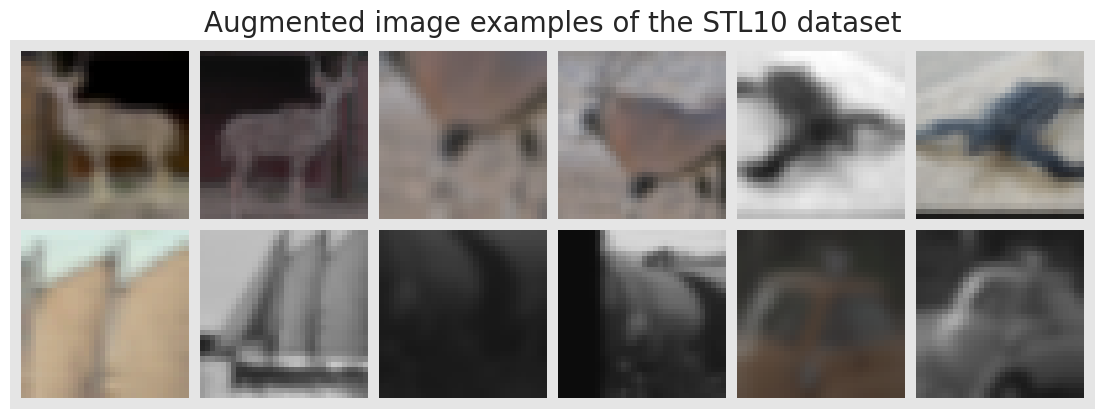

In [38]:
# Visualize some examples
pl.seed_everything(42)
NUM_IMAGES = 6
imgs = torch.stack([img for idx in range(NUM_IMAGES) for img in unlabeled_data[idx][0]], dim=0)
img_grid = torchvision.utils.make_grid(imgs, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(14,7))
plt.title('Augmented image examples of the STL10 dataset', fontsize=20)
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

We see the wide variety of our data augmentation, including randomly cropping, grayscaling, gaussian blur, and color distortion. Thus, it remains a challenging task for the model to match two, independently augmented patches of the same image.

## Part 1: SimCLR implementation

Using the data loader pipeline above, we can now implement SimCLR. At each iteration, we get for every image $x$ two differently augmented versions, which we refer to as $\tilde{x}_i$ and $\tilde{x}_j$. Both of these images are encoded into a one-dimensional feature vector, between which we want to maximize similarity which minimizes it to all other images in the batch. The encoder network is split into two parts: a base encoder network $f(\cdot)$, and a projection head $g(\cdot)$. The base network is usually a deep CNN as we have seen in e.g. [Tutorial 5](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial5/Inception_ResNet_DenseNet.html) before, and is responsible for extracting a representation vector from the augmented data examples. In our experiments, we will use the common ResNet-18 architecture as $f(\cdot)$, and refer to the output as $f(\tilde{x}_i)=h_i$. The projection head $g(\cdot)$ maps the representation $h$ into a space where we apply the contrastive loss, i.e., compare similarities between vectors. It is often chosen to be a small MLP with non-linearities, and for simplicity, we follow the original SimCLR paper setup by defining it as a two-layer MLP with ReLU activation in the hidden layer. Note that in the follow-up paper, [SimCLRv2](https://arxiv.org/abs/2006.10029), the authors mention that larger/wider MLPs can boost the performance considerably. This is why we apply an MLP with four times larger hidden dimensions, but deeper MLPs showed to overfit on the given dataset. The general setup is visualized below (figure credit - [Ting Chen et al.](https://arxiv.org/abs/2006.10029)):

<center width="100%"><img src="https://github.com/Ehsan-aghapour/asci_cbl_practicals/blob/main/notebooks/figures/simclr_network_setup.svg?raw=1" width="350px"></center>

After finishing the training with contrastive learning, we will remove the projection head $g(\cdot)$, and use $f(\cdot)$ as a pretrained feature extractor. The representations $z$ that come out of the projection head $g(\cdot)$ have been shown to perform worse than those of the base network $f(\cdot)$ when finetuning the network for a new task. This is likely because the representations $z$ are trained to become invariant to many features like the color that can be important for downstream tasks. Thus, $g(\cdot)$ is only needed for the contrastive learning stage.

Let's first start by implementing a Base Network which will represent function $f(\cdot)$. Usually, you would use very large, powerful networks like a deep ResNet, but these are very expensive to train. To reduce the computational cost and make it possible to reasonable train the models on Google Colab, we provide a very simple CNN here:

In [39]:
class BaseNetwork(nn.Module):

    def __init__(self, num_input_channels, c_hid, output_dim):
        """
        Inputs:
            - num_input_channels : Number of input channels of the image. For CIFAR, this parameter is 3
            - c_hid : Number of channels we use in the first convolutional layers. Deeper layers might use a duplicate of it.
            - output_dim : Dimensionality of the final latent representation
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(num_input_channels, c_hid, kernel_size=3, padding=1, stride=2), # 32x32 => 16x16
            nn.BatchNorm2d(c_hid),
            nn.SiLU(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            nn.BatchNorm2d(c_hid),
            nn.SiLU(),
            nn.Conv2d(c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2), # 16x16 => 8x8
            nn.BatchNorm2d(2*c_hid),
            nn.SiLU(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1),
            nn.BatchNorm2d(2*c_hid),
            nn.SiLU(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2), # 8x8 => 4x4
            nn.BatchNorm2d(2*c_hid),
            nn.SiLU(),
            nn.Flatten(), # Image grid to single feature vector
            nn.Linear(2*16*c_hid, output_dim)
        )

    def forward(self, x):
        return self.net(x)

Now that the architecture is described, let's take a closer look at how we train the model. As mentioned before, we want to maximize the similarity between the representations of the two augmented versions of the same image, i.e., $z_i$ and $z_j$ in the figure above, while minimizing it to all other examples in the batch. SimCLR thereby applies the InfoNCE loss, originally proposed by [Aaron van den Oord et al.](https://arxiv.org/abs/1807.03748) for contrastive learning. In short, the InfoNCE loss compares the similarity of $z_i$ and $z_j$ to the similarity of $z_i$ to any other representation in the batch by performing a softmax over the similarity values. The loss can be formally written as:

$$
\ell_{i,j}=-\log \frac{\exp(\text{sim}(z_i,z_j)/\tau)}{\sum_{k=1}^{2N}\mathbb{1}_{[k\neq i]}\exp(\text{sim}(z_i,z_k)/\tau)}=-\text{sim}(z_i,z_j)/\tau+\log\left[\sum_{k=1}^{2N}\mathbb{1}_{[k\neq i]}\exp(\text{sim}(z_i,z_k)/\tau)\right]
$$

The function $\text{sim}$ is a similarity metric, and the hyperparameter $\tau$ is called temperature determining how peaked the distribution is. Since many similarity metrics are bounded, the temperature parameter allows us to balance the influence of many dissimilar image patches versus one similar patch. The similarity metric that is used in SimCLR is cosine similarity, as defined below:

$$
\text{sim}(z_i,z_j) = \frac{z_i^\top \cdot z_j}{||z_i||\cdot||z_j||}
$$

The maximum cosine similarity possible is $1$, while the minimum is $-1$. In general, we will see that the features of two different images will converge to a cosine similarity around zero since the minimum, $-1$, would require $z_i$ and $z_j$ to be in the exact opposite direction in all feature dimensions, which does not allow for great flexibility.

Finally, now that we have discussed all details, let's implement SimCLR below as a PyTorch Lightning module:

In [40]:
class SimCLR(pl.LightningModule):

    def __init__(self, hidden_dim, lr, temperature, weight_decay, max_epochs=500):
        super().__init__()
        self.save_hyperparameters()
        assert self.hparams.temperature > 0.0, 'The temperature must be a positive float!'
        # TODO: Setup the Base Network
        # raise NotImplementedError

        self.base_encoder = BaseNetwork(num_input_channels=3, c_hid=64, output_dim=hidden_dim)
        self.projection_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 4),
            nn.ReLU(),
            nn.Linear(hidden_dim * 4, hidden_dim)
        )

    def forward(self,x):
        return self.projection_head(self.base_encoder(x))

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(),
                                lr=self.hparams.lr,
                                weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                            T_max=self.hparams.max_epochs,
                                                            eta_min=self.hparams.lr/50)
        return [optimizer], [lr_scheduler]

    def info_nce_loss(self, batch, mode='train'):
        imgs, _ = batch  # we do not need the labels here
        # imgs is a list of length 2, where imgs[0][i] and imgs[1][i] are the positive pairs

        # TODO: Calculate the contrastive loss of SimCLR. Try to be as efficient as possible
        # Hint: if you add imgs into a batch where over dimension 0, you have [imgs[0],imgs[1]],
        # the positive pair for an image at position i is always at (i + batch_size) % (2 * batch_size)
        # Can you create a mask to find the positive element for each batch element?
        # raise NotImplementedError

        imgs = torch.cat(imgs, dim=0)

        features = self.projection_head(self.base_encoder(imgs))
        features = F.normalize(features, dim=1)

        # Calculates the batch size by dividing the total number of images (imgs.size(0)) by 2, as each image has an augmented pair.
        batch_size = imgs.size(0) // 2

        # Creates a tensor labels that represents the positive pairs. For each image in the batch, it assigns a unique label, and the augmented pair of that image gets the same label. This way, the model knows which images are positive pairs.
        labels = torch.cat([torch.arange(batch_size) for _ in range(2)], dim=0).to(self.device)
        similarity_matrix = torch.matmul(features, features.T)

        mask = torch.eye(labels.size(0), dtype=torch.bool).to(self.device)
        positives = similarity_matrix[~mask].view(labels.size(0), -1)[range(labels.size(0)), labels]
        negatives = similarity_matrix[~mask].view(labels.size(0), -1)

        logits = torch.cat([positives.unsqueeze(1), negatives], dim=1)
        logits /= self.hparams.temperature

        # TODO: Log the loss and the top-1 and top-5 accuracy as how often the most similar image was the positive
        # You can also split this part into another function if you prefer
        # raise NotImplementedError

        loss = F.cross_entropy(logits, torch.zeros(labels.size(0), dtype=torch.long).to(self.device))

        with torch.no_grad():
            top1 = (logits.argmax(dim=1) == 0).float().mean()
            top5 = (logits.topk(5, dim=1).indices == 0).any(dim=1).float().mean()
            self.log(f'{mode}_acc_top1', top1, prog_bar=True, on_epoch=True)
            self.log(f'{mode}_acc_top5', top5, prog_bar=True, on_epoch=True)

        # self.log(mode+'_acc_top1', ...)
        # self.log(mode+'_acc_top5', ...)

        return loss

    def training_step(self, batch, batch_idx):
        return self.info_nce_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        return self.info_nce_loss(batch, mode='val')



In [41]:
# TODO: Create some test cases yourself to check the INFO-NCE loss and the logging!
# raise NotImplementedError

def test_info_nce_loss():
    model = SimCLR(hidden_dim=128, lr=1e-3, temperature=0.5, weight_decay=1e-4, max_epochs=10)

    batch_size = 8
    img_size = (3, 32, 32)
    imgs1 = torch.randn(batch_size, *img_size)
    imgs2 = torch.randn(batch_size, *img_size)
    batch = ([imgs1, imgs2], None)

    # Forward pass through the model
    loss = model.info_nce_loss(batch, mode='test')
    print(f"INFO-NCE Loss: {loss.item()}")

def test_logging():
    model = SimCLR(hidden_dim=128, lr=1e-3, temperature=0.5, weight_decay=1e-4, max_epochs=10)

    batch_size = 8
    img_size = (3, 32, 32)
    imgs1 = torch.randn(batch_size, *img_size)
    imgs2 = torch.randn(batch_size, *img_size)
    batch = ([imgs1, imgs2], None)

    # Simulate training step
    model.training_step(batch, batch_idx=0)

test_info_nce_loss()
test_logging()


INFO-NCE Loss: 2.798661470413208


/home/ehsan/.local/lib/python3.10/site-packages/pytorch_lightning/core/module.py:441: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


Alternatively to performing the validation on the contrastive learning loss as well, we could also take a simple, small downstream task, and track the performance of the base network $f(\cdot)$ on that. However, in this tutorial, we will restrict ourselves to the STL10 dataset where we use the task of image classification on STL10 as our test task.

### Training

Now that we have implemented SimCLR and the data loading pipeline, we are ready to train the model. We will use the same training function setup as usual. For saving the best model checkpoint, we track the metric `val_acc_top5`, which describes how often the correct image patch is within the top-5 most similar examples in the batch. This is usually less noisy than the top-1 metric, making it a better metric to choose the best model from.

In [42]:
from pytorch_lightning.callbacks import TQDMProgressBar,RichProgressBar
def train_simclr(batch_size, max_epochs=500, **kwargs):
    root_dir=os.path.join(CHECKPOINT_PATH, 'SimCLR')
    trainer = pl.Trainer(default_root_dir=root_dir,
                        #  gpus=1 if str(device)=='cuda:0' else 0,
                         accelerator="auto",
                         max_epochs=max_epochs,
                         callbacks=[ModelCheckpoint(save_weights_only=False, mode='max', monitor='val_acc_top5',save_last=True,dirpath=root_dir,),
                                    LearningRateMonitor('epoch'),RichProgressBar(),],
                         check_val_every_n_epoch=1,
                         #log_every_n_steps=1,
                         enable_progress_bar=True,
    )
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, 'SimCLR.ckpt')
    if os.path.isfile(pretrained_filename):
        print(f'Found pretrained model at {pretrained_filename}, loading...')
        model = SimCLR.load_from_checkpoint(pretrained_filename) # Automatically loads the model with the saved hyperparameters
    else:
        # Check if a checkpoint exists
        latest_checkpoint = os.path.join(root_dir, "last.ckpt")
        if os.path.isfile(latest_checkpoint):
            print(f"Found checkpoint at {latest_checkpoint}, resuming training...")
            ckpt_path = latest_checkpoint
        else:
            print(f"No checkpoint found at {latest_checkpoint}, starting training from scratch.")
            ckpt_path = None
        train_loader = data.DataLoader(unlabeled_data, batch_size=batch_size, shuffle=True,
                                       drop_last=True, pin_memory=True, num_workers=NUM_WORKERS)
        val_loader = data.DataLoader(train_data_contrast, batch_size=batch_size, shuffle=False,
                                     drop_last=False, pin_memory=True, num_workers=NUM_WORKERS)
        pl.seed_everything(42) # To be reproducable
        model = SimCLR(max_epochs=max_epochs, **kwargs)
        trainer.fit(model, train_loader, val_loader,ckpt_path=ckpt_path)
        model = SimCLR.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) # Load best checkpoint after training

    return model

A common observation in contrastive learning is that the larger the batch size, the better the models perform. A larger batch size allows us to compare each image to more negative examples, leading to overall smoother loss gradients, but a batch size of 256 is sufficient here. Again, for a first run, you can use 10 epochs, but try to increase the number of epochs for a final run.

In [43]:
simclr_model = train_simclr(batch_size=256,
                            hidden_dim=128,
                            lr=5e-4,
                            temperature=0.07,
                            weight_decay=1e-4,
                            max_epochs=100)

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 42
/home/ehsan/.local/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/ehsan/saved_models/practical5/SimCLR exists and is not empty.
Restoring states from the checkpoint path at /home/ehsan/saved_models/practical5/SimCLR/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Found checkpoint at /home/ehsan/saved_models/practical5/SimCLR/last.ckpt, resuming training...


┏━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name            ┃ Type        ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ base_encoder    │ BaseNetwork │  671 K │ train │
│ 1 │ projection_head │ Sequential  │  131 K │ train │
└───┴─────────────────┴─────────────┴────────┴───────┘

Trainable params: 802 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 802 K                                                                                                
Total estimated model params size (MB): 3                                                                          
Modules in train mode: 23                                                                                          
Modules in eval mode: 0

Restored all states from the checkpoint at /home/ehsan/saved_models/practical5/SimCLR/last.ckpt


Output()

`Trainer.fit` stopped: `max_epochs=100` reached.


To get an intuition of how training with contrastive learning behaves, we can take a look at the TensorBoard below:

In [44]:
if False:
    import torch
    import pytorch_lightning as pl
    from pytorch_lightning.callbacks import TQDMProgressBar
    import torch.nn.functional as F
    from pytorch_lightning.callbacks import RichProgressBar



    class DummyModel(pl.LightningModule):
        def __init__(self):
            super().__init__()
            self.layer = torch.nn.Linear(10, 10)

        def forward(self, x):
            return self.layer(x)

        def training_step(self, batch, batch_idx):
            x, y = batch
            preds = self(x)
            loss = F.mse_loss(preds, y)
            self.log("train_loss", loss, prog_bar=True)
            #print(f"Batch {batch_idx} done!")  # Debug print
            return loss
        def training_step(self, batch, batch_idx):
            x, y = batch
            preds = self(x)
            loss = F.mse_loss(preds, y)
            self.log("train_loss", loss, prog_bar=True)
            self.log("mean_pred", preds.mean(), prog_bar=True)  # Log additional parameter: mean of predictions
            self.log("std_pred", preds.std(), prog_bar=True)    # Log standard deviation of predictions
            return loss

        def configure_optimizers(self):
            return torch.optim.Adam(self.parameters(), lr=1e-3)

    # Generate dummy data
    data_x = torch.randn(64, 10)
    data_y = torch.randn(64, 10)
    dataset = torch.utils.data.TensorDataset(data_x, data_y)
    loader = torch.utils.data.DataLoader(dataset, batch_size=8)

    model = DummyModel()

    trainer = pl.Trainer(
        max_epochs=200,
        enable_progress_bar=True,
        #callbacks=[TQDMProgressBar(refresh_rate=1)],
        callbacks=[RichProgressBar()],
        log_every_n_steps=1
    )



    trainer.fit(model, loader)


In [45]:
%tensorboard --logdir ../saved_models/practical5/SimCLR/

In your report, show the top-1 and top-5 accuracy validation curves. Discuss the overall performance and the training speed. Is the model already converged? What does the final performance of the model imply about the learned feature space?

## Part 2: Logistic Regression

After we have trained our model via contrastive learning, we can deploy it on downstream tasks and see how well it performs with little data. A common setup, which also verifies whether the model has learned generalized representations, is to perform Logistic Regression on the features. In other words, we learn a single, linear layer that maps the representations to a class prediction. Since the base network $f(\cdot)$ is not changed during the training process, the model can only perform well if the representations of $h$ describe all features that might be necessary for the task. Further, we do not have to worry too much about overfitting since we have very few parameters that are trained. Hence, we might expect that the model can perform well even with very little data.

First, let's implement a simple Logistic Regression setup for which we assume that the images already have been encoded in their feature vectors. If very little data is available, it might be beneficial to dynamically encode the images during training so that we can also apply data augmentations. However, the way we implement it here is much more efficient and can be trained within a few seconds. Further, using data augmentations did not show any significant gain in this simple setup.

In [46]:
class LogisticRegression(pl.LightningModule):

    def __init__(self, feature_dim, num_classes, lr, weight_decay, max_epochs=100):
        super().__init__()
        self.save_hyperparameters()
        # Mapping from representation h to classes
        # TODO: Initialize logistic regression model
        # raise NotImplementedError
        self.linear = nn.Linear(feature_dim, num_classes)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(),
                                lr=self.hparams.lr,
                                weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                                      milestones=[int(self.hparams.max_epochs*0.6),
                                                                  int(self.hparams.max_epochs*0.8)],
                                                      gamma=0.1)
        return [optimizer], [lr_scheduler]

    def _calculate_loss(self, batch, mode='train'):
        # TODO: Calculate classification loss for logistic regression model
        # raise NotImplementedError
        features, labels = batch
        logits = self.linear(features)
        loss = F.cross_entropy(logits, labels)

        with torch.no_grad():
            acc = (logits.argmax(dim=1) == labels).float().mean()
            self.log(f'{mode}_loss', loss, prog_bar=True)
            self.log(f'{mode}_acc', acc, prog_bar=True)
        return loss

    def training_step(self, batch, batch_idx):
        return self._calculate_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode='val')

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode='test')

The data we use is the training and test set of STL10. The training contains 500 images per class, while the test set has 800 images per class.

In [47]:
img_transforms = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.5,), (0.5,))])

train_img_data = STL10(root=DATASET_PATH, split='train', download=True,
                       transform=img_transforms)
test_img_data = STL10(root=DATASET_PATH, split='test', download=True,
                      transform=img_transforms)
downscale_dataset(train_img_data)
downscale_dataset(test_img_data)

print("Number of training examples:", len(train_img_data))
print("Number of test examples:", len(test_img_data))

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

Number of training examples: 5000
Number of test examples: 8000


Next, we implement a small function to encode all images in our datasets. The output representations are then used as inputs to the Logistic Regression model.

In [48]:
@torch.no_grad()
def prepare_data_features(model, dataset):
    # TODO: Obtain the feature representation for all images in the dataset
    # raise NotImplementedError

    model.eval()
    dataloader = data.DataLoader(dataset, batch_size=64, shuffle=False, num_workers=4)
    feats, labels = [], []

    for imgs, lbls in dataloader:
        features = model(imgs.cuda() if torch.cuda.is_available() else imgs)
        feats.append(features.cpu())
        labels.append(lbls)

    feats = torch.cat(feats, dim=0)
    labels = torch.cat(labels, dim=0)

    # Return a new dataset with the image features and labels
    return data.TensorDataset(feats, labels)

Let's apply the function to both training and test set below.

In [49]:
train_feats_simclr = prepare_data_features(simclr_model, train_img_data)
test_feats_simclr = prepare_data_features(simclr_model, test_img_data)

Finally, we can write a training function as usual. We evaluate the model on the test set every 10 epochs to allow early stopping, but the low frequency of the validation ensures that we do not overfit too much on the test set.

In [50]:
def train_logreg_0(batch_size, train_feats_data, test_feats_data, model_suffix, max_epochs=100, **kwargs):
    root_dir=os.path.join(CHECKPOINT_PATH, 'SimCLR')
    trainer = pl.Trainer(default_root_dir=root_dir,
                        #  gpus=1 if str(device)=='cuda:0' else 0,
                         accelerator="auto",
                         max_epochs=max_epochs,
                         callbacks=[ModelCheckpoint(save_weights_only=False, mode='max', monitor='val_acc_top5',save_last=True,dirpath=root_dir,),
                                    LearningRateMonitor('epoch'),RichProgressBar(),],
                         check_val_every_n_epoch=1,
                         #log_every_n_steps=1,
                         enable_progress_bar=True,
    )

    trainer.logger._default_hp_metric = None

    # Data loaders
    train_loader = data.DataLoader(train_feats_data, batch_size=batch_size, shuffle=True,
                                   drop_last=False, pin_memory=True, num_workers=0)
    test_loader = data.DataLoader(test_feats_data, batch_size=batch_size, shuffle=False,
                                  drop_last=False, pin_memory=True, num_workers=0)

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, f"LogisticRegression_{model_suffix}.ckpt")
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        model = LogisticRegression.load_from_checkpoint(pretrained_filename)
    else:
        # Check if a checkpoint exists
        latest_checkpoint = os.path.join(root_dir, "last.ckpt")
        if os.path.isfile(latest_checkpoint):
            print(f"Found checkpoint at {latest_checkpoint}, resuming training...")
            ckpt_path = latest_checkpoint
        else:
            print(f"No checkpoint found at {latest_checkpoint}, starting training from scratch.")
            ckpt_path = None
        pl.seed_everything(42)  # To be reproducable
        model = LogisticRegression(**kwargs)
        trainer.fit(model, train_loader, test_loader,ckpt_path=ckpt_path)
        model = LogisticRegression.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test best model on train and validation set
    train_result = trainer.test(model, train_loader, verbose=False)
    test_result = trainer.test(model, test_loader, verbose=False)
    result = {"train": train_result[0]["test_acc"], "test": test_result[0]["test_acc"]}

    return model, result

def train_logreg(batch_size, train_feats_data, test_feats_data, model_suffix, max_epochs=100, **kwargs):
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, "LogisticRegression"),
                        #  gpus=1 if str(device)=="cuda:0" else 0,
                         accelerator="auto",
                         max_epochs=max_epochs,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode='max', monitor='val_acc'),
                                    LearningRateMonitor("epoch")],
                        #  progress_bar_refresh_rate=0,
                         check_val_every_n_epoch=10)
    trainer.logger._default_hp_metric = None

    # Data loaders
    train_loader = data.DataLoader(train_feats_data, batch_size=batch_size, shuffle=True,
                                   drop_last=False, pin_memory=True, num_workers=0)
    test_loader = data.DataLoader(test_feats_data, batch_size=batch_size, shuffle=False,
                                  drop_last=False, pin_memory=True, num_workers=0)

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, f"LogisticRegression_{model_suffix}.ckpt")
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        model = LogisticRegression.load_from_checkpoint(pretrained_filename)
    else:
        pl.seed_everything(42)  # To be reproducable
        model = LogisticRegression(**kwargs)
        trainer.fit(model, train_loader, test_loader)
        model = LogisticRegression.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test best model on train and validation set
    train_result = trainer.test(model, train_loader, verbose=False)
    test_result = trainer.test(model, test_loader, verbose=False)
    result = {"train": train_result[0]["test_acc"], "test": test_result[0]["test_acc"]}

    return model, result

Despite the training dataset of STL10 already only having 500 labeled images per class, we will perform experiments with even smaller datasets. Specifically, we train a Logistic Regression model for datasets with only 10, 20, 50, 100, 200, and all 500 examples per class. This gives us an intuition on how well the representations learned by contrastive learning can be transfered to a image recognition task like this classification. First, let's define a function to create the intended sub-datasets from the full training set:

In [51]:
def get_smaller_dataset(original_dataset, num_imgs_per_label):
    # TODO: Return dataset with the first N images per label
    # raise NotImplementedError
    return data.TensorDataset(*[t.unflatten(0, (10, -1))[:,:num_imgs_per_label].flatten(0, 1) for t in original_dataset.tensors])

Next, let's run all models. Despite us training 6 models, this cell could be run within a minute or two without the pretrained models.

In [52]:
# TODO: Run the logistic regression on datasets of 10, 20, 50, 100, 200, and 500 labeled examples
# raise NotImplementedError
res =  {}
for num_samples in [10, 20, 50, 100, 200, 500]:
    sub_train_set = get_smaller_dataset(train_feats_simclr, num_samples)
    res[num_samples] = train_logreg(batch_size=64, num_classes=10, lr=1e-3, weight_decay=1e-3,
                                        train_feats_data=sub_train_set, test_feats_data=test_feats_simclr,
                                        model_suffix=num_samples, feature_dim=train_feats_simclr.tensors[0].shape[1], max_epochs=100)
    print(f"Number of samples: {num_samples} - {res[num_samples][1]}")

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name   | Type   | Params | Mode 
------------------------------------------
0 | linear | Linear | 1.3 K  | train
------------------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: |          | 0/? [00:00<?, ?it/s]

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name   | Type   | Params | Mode 
------------------------------------------
0 | linear | Linear | 1.3 K  | train
------------------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode


Number of samples: 10 - {'train': 1.0, 'test': 0.24012500047683716}


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: |          | 0/? [00:00<?, ?it/s]

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name   | Type   | Params | Mode 
------------------------------------------
0 | linear | Linear | 1.3 K  | train
------------------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode


Number of samples: 20 - {'train': 0.9900000095367432, 'test': 0.31562501192092896}


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: |          | 0/? [00:00<?, ?it/s]

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name   | Type   | Params | Mode 
------------------------------------------
0 | linear | Linear | 1.3 K  | train
------------------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode


Number of samples: 50 - {'train': 0.9679999947547913, 'test': 0.42362499237060547}


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: |          | 0/? [00:00<?, ?it/s]

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name   | Type   | Params | Mode 
------------------------------------------
0 | linear | Linear | 1.3 K  | train
------------------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode


Number of samples: 100 - {'train': 0.8050000071525574, 'test': 0.5}


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: |          | 0/? [00:00<?, ?it/s]

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name   | Type   | Params | Mode 
------------------------------------------
0 | linear | Linear | 1.3 K  | train
------------------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode


Number of samples: 200 - {'train': 0.7269999980926514, 'test': 0.5392500162124634}


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: |          | 0/? [00:00<?, ?it/s]

Number of samples: 500 - {'train': 0.6611999869346619, 'test': 0.5820000171661377}


Finally, let's plot the results.

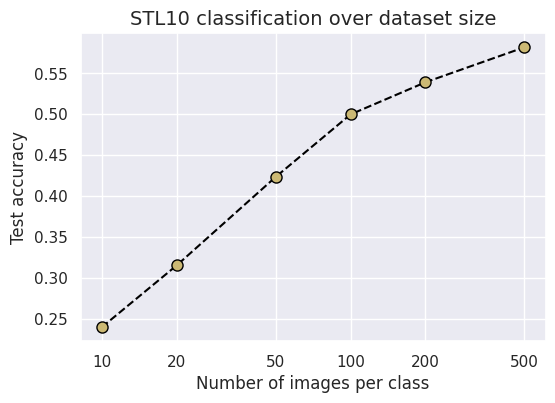

Test accuracy for  10 images per label: 24.01%
Test accuracy for  20 images per label: 31.56%
Test accuracy for  50 images per label: 42.36%
Test accuracy for 100 images per label: 50.00%
Test accuracy for 200 images per label: 53.93%
Test accuracy for 500 images per label: 58.20%


In [53]:
# TODO: Plot the results
# raise NotImplementedError

num_samples = sorted(res.keys())
test_acc = [res[k][1]["test"] for k in num_samples]

fig = plt.figure(figsize=(6,4))
plt.plot(num_samples, test_acc, '--', color="#000", marker=".", markeredgecolor="#000", markerfacecolor="y", markersize=16)
plt.xscale("log")
plt.xticks(num_samples, labels=num_samples)
plt.title("STL10 classification over dataset size", fontsize=14)
plt.xlabel("Number of images per class")
plt.ylabel("Test accuracy")
plt.minorticks_off()
plt.show()

for k, score in zip(num_samples, test_acc):
    print(f'Test accuracy for {k:3d} images per label: {100*score:4.2f}%')

Add the plot in your report and discuss the overall performance as well as the trend you see in the plot. Where do you see the biggest jump in performance? Is the performance already saturating?

## Part 3: Baseline

As a baseline to our results above, we will train the BaseNetwork with random initialization on the labeled training set of STL10. The results will give us an indication of the advantages that contrastive learning on unlabeled data has compared to using only supervised training. First, let's implement it below.

In [54]:
class Baseline(pl.LightningModule):

    def __init__(self,feature_dim, num_classes, lr, weight_decay, max_epochs=100):
        super().__init__()
        self.save_hyperparameters()
        # TODO: Initialize a base network
        # raise NotImplementedError
        self.base_encoder = BaseNetwork(3, self.hparams.feature_dim, 4*self.hparams.feature_dim)
        self.projection_head = nn.Sequential(nn.ReLU(inplace=True), nn.Linear(4*self.hparams.feature_dim, num_classes))

        # self.base_encoder = BaseNetwork(num_input_channels=3, c_hid=64, output_dim=hidden_dim)
        # self.projection_head = nn.Sequential(
        #     nn.Linear(hidden_dim, hidden_dim * 4),
        #     nn.ReLU(),
        #     nn.Linear(hidden_dim * 4, hidden_dim)
        # )

    def forward(self, x):
        return self.projection_head(self.base_encoder(x))

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(),
                                lr=self.hparams.lr,
                                weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                                      milestones=[int(self.hparams.max_epochs*0.7),
                                                                  int(self.hparams.max_epochs*0.9)],
                                                      gamma=0.1)
        return [optimizer], [lr_scheduler]

    def _calculate_loss(self, batch, mode='train'):
        # TODO: Calculate classification loss and accuracy
        # raise NotImplementedError
        imgs, labels = batch
        preds = self(imgs)
        loss = F.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()
        self.log(mode + '_loss', loss)
        self.log(mode + '_acc', acc)
        return loss

    def training_step(self, batch, batch_idx):
        return self._calculate_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode='val')

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode='test')

It is clear that the ResNet easily overfits on the training data since its parameter count is more than 1000 times larger than the dataset size. To make the comparison to the contrastive learning models fair, we apply data augmentations similar to the ones we used before: horizontal flip, crop-and-resize, grayscale, and gaussian blur. Color distortions as before are not used because the color distribution of an image showed to be an important feature for the classification. Hence, we observed no noticeable performance gains when adding color distortions to the set of augmentations. Similarly, we restrict the resizing operation before cropping to the max. 125% of its original resolution, instead of 1250% as done in SimCLR. This is because, for classification, the model needs to recognize the full object, while in contrastive learning, we only want to check whether two patches belong to the same image/object. Hence, the chosen augmentations below are overall weaker than in the contrastive learning case.

In [55]:
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.RandomResizedCrop(size=32, scale=(0.8, 1.0)),
                                       transforms.RandomGrayscale(p=0.2),
                                       transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 0.5)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5,), (0.5,))
                                       ])

train_img_aug_data = STL10(root=DATASET_PATH, split='train', download=True,
                           transform=train_transforms)
downscale_dataset(train_img_aug_data)

Files already downloaded and verified


  0%|          | 0/50 [00:00<?, ?it/s]

The training function for the ResNet is almost identical to the Logistic Regression setup. Note that we allow the ResNet to perform validation every 2 epochs to also check whether the model overfits strongly in the first iterations or not.

In [56]:
def train_baseline(batch_size, max_epochs=100, **kwargs):
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, "ResNet"),
                        #  gpus=1 if str(device)=="cuda:0" else 0,
                         accelerator="auto",
                         max_epochs=max_epochs,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),
                                    LearningRateMonitor("epoch"),RichProgressBar()],
                        #  progress_bar_refresh_rate=1,
                         check_val_every_n_epoch=10)
    trainer.logger._default_hp_metric = None

    # Data loaders
    train_loader = data.DataLoader(train_img_aug_data, batch_size=batch_size, shuffle=True,
                                   drop_last=True, pin_memory=True, num_workers=NUM_WORKERS)
    test_loader = data.DataLoader(test_img_data, batch_size=batch_size, shuffle=False,
                                  drop_last=False, pin_memory=True, num_workers=NUM_WORKERS)

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "ResNet.ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model at %s, loading..." % pretrained_filename)
        model = Baseline.load_from_checkpoint(pretrained_filename)
    else:
        pl.seed_everything(42) # To be reproducable
        model = Baseline(**kwargs)
        trainer.fit(model, train_loader, test_loader)
        model = Baseline.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test best model on validation set
    train_result = trainer.test(model, train_loader, verbose=False)
    val_result = trainer.test(model, test_loader, verbose=False)
    result = {"train": train_result[0]["test_acc"], "test": val_result[0]["test_acc"]}

    return model, result

Finally, let's train the model and check its results. For a first run, use 10 epochs, but to obtain final results, try to train the model on more epochs.

In [57]:
baseline_model, baseline_result = train_baseline(batch_size=64, feature_dim=128,
                                               num_classes=10,
                                               lr=1e-3,
                                               weight_decay=2e-4,
                                               max_epochs=100)

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


┏━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name            ┃ Type        ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ base_encoder    │ BaseNetwork │  3.7 M │ train │
│ 1 │ projection_head │ Sequential  │  5.1 K │ train │
└───┴─────────────────┴─────────────┴────────┴───────┘

Trainable params: 3.7 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.7 M                                                                                                
Total estimated model params size (MB): 14                                                                         
Modules in train mode: 22                                                                                          
Modules in eval mode: 0

Output()

`Trainer.fit` stopped: `max_epochs=100` reached.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Output()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Output()

In [58]:
print(f"Accuracy on training set: {baseline_result['train']:.2%}")
print(f"Accuracy on test set: {baseline_result['test']:.2%}")

Accuracy on training set: 99.12%
Accuracy on test set: 64.79%


In your report, note the results you have obtained from this baseline and compare it to the logistic regression model in Part 2. What do you see? What do the results imply?

## Conclusion

In this tutorial, we have discussed self-supervised contrastive learning and implemented SimCLR as an example method. We have applied it to the STL10 dataset and showed that it can learn generalizable representations that we can use to train simple classification models. Besides the discussed hyperparameters, the size of the model seems to be important in contrastive learning as well. If a lot of unlabeled data is available, larger models can achieve much stronger results and come close to their supervised baselines. Further, there are also approaches for combining contrastive and supervised learning, leading to performance gains beyond supervision (see [Khosla et al.](https://arxiv.org/abs/2004.11362)). Moreover, contrastive learning is not the only approach to self-supervised learning that has come up in the last two years and showed great results. Other methods include distillation-based methods like [BYOL](https://arxiv.org/abs/2006.07733) and redundancy reduction techniques like [Barlow Twins](https://arxiv.org/abs/2103.03230). There is a lot more to explore in the self-supervised domain.

### References

[1] Chen, T., Kornblith, S., Norouzi, M., and Hinton, G. (2020). A simple framework for contrastive learning of visual representations. In International conference on machine learning (pp. 1597-1607). PMLR. ([link](https://arxiv.org/abs/2002.05709))

[2] Chen, T., Kornblith, S., Swersky, K., Norouzi, M., and Hinton, G. (2020). Big self-supervised models are strong semi-supervised learners. NeurIPS 2021 ([link](https://arxiv.org/abs/2006.10029)).

[3] Oord, A. V. D., Li, Y., and Vinyals, O. (2018). Representation learning with contrastive predictive coding. arXiv preprint arXiv:1807.03748. ([link](https://arxiv.org/abs/1807.03748))

[4] Grill, J.B., Strub, F., Altché, F., Tallec, C., Richemond, P.H., Buchatskaya, E., Doersch, C., Pires, B.A., Guo, Z.D., Azar, M.G. and Piot, B. (2020). Bootstrap your own latent: A new approach to self-supervised learning. arXiv preprint arXiv:2006.07733. ([link](https://arxiv.org/abs/2006.07733))

[5] Khosla, P., Teterwak, P., Wang, C., Sarna, A., Tian, Y., Isola, P., Maschinot, A., Liu, C. and Krishnan, D. (2020). Supervised contrastive learning. arXiv preprint arXiv:2004.11362. ([link](https://arxiv.org/abs/2004.11362))

[6] Zbontar, J., Jing, L., Misra, I., LeCun, Y. and Deny, S. (2021). Barlow twins: Self-supervised learning via redundancy reduction. arXiv preprint arXiv:2103.03230. ([link](https://arxiv.org/abs/2103.03230))